# Setup variables

Define the main variables

In [1]:
CHECKPOINT_NAME="eff_gat_epoch_30_steps_2_batchsize_10_puzzdim_6_6.pt"

In [2]:
import sys
import os

IN_COLAB = "google.colab" in sys.modules
print(IN_COLAB)

# Set IN_COLAB as an environment variable to be seen by bash scripts
os.environ["IN_COLAB"] = "1" if IN_COLAB else "0"

False


# Installation

Verify your python version.
Note that this notebook has been tested with python version 3.12.3

In [3]:
!python --version

Python 3.12.3


⚠ Install the required packages only if this notebook runs in Colab. Otherwise you should install the required packages manually on your local python environment.

Install the version 2.6.0 of torch version to be able to install later compatible pytorch-geometric packages

In [4]:
if IN_COLAB:
  !pip uninstall -y torch torchvision torchaudio
  !pip install -q torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cpu

In [5]:
import torch

if IN_COLAB:
  torch_version = torch.__version__.split('+')[0]
  !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_version}+cpu.html
  !pip install -q torch-geometric

## Inspect runtime default versions and settings

Check torch and torchvision default versions. For now we are just going to use them, we'll change them if we hit any conflict in the future.

In [6]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print("")
print(f"Torch cuda is available: {torch.cuda.is_available()}")

Torch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126

Torch cuda is available: True


# Import our code

Import the classes of the deep-learning-puzzle-project repository

In [7]:
%%bash

if [ "$IN_COLAB" == "0" ]; then
  echo "Skipping download (IN_COLAB is false)"
  exit 0
fi

REPO_DIR_NAME="deep-learning-puzzle-project"
rm -r ${REPO_DIR_NAME}
git clone https://github.com/silviasuhu/deep-learning-puzzle-project.git


Skipping download (IN_COLAB is false)


Move to the root directory of the repo to get consistency between Colab and local executions

In [8]:
import os
import sys

current_dir = os.path.basename(os.getcwd())
print(current_dir)

if current_dir == "deep-learning-puzzle-project":
    print("You are already on the root directory of the 'deep-learning-puzzle-project' repo.")

else:
  if IN_COLAB:
    %cd "deep-learning-puzzle-project"
  else:
    %cd ".."

notebooks
/home/silvia/projects/deep-learning-puzzle-project


## Main imports

In [9]:
import os
from pathlib import Path
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import numpy as np
import einops

import torch
import torch_geometric
import torchvision

/home/silvia/projects/deep-learning-puzzle-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset download

Download the dataset only if this notebook runs in Colab, otherwise you'll need to download it manually.

In [12]:
import os

DATASET_PATH="data/CelebA-HQ"
os.environ["DATASET_PATH"] = DATASET_PATH

In [13]:
%%bash

if [ "$IN_COLAB" == "0" ]; then
  echo "Skipping download (IN_COLAB is false)"
  exit 0
fi

echo 'Downloading dataset...'

OUTPUT_FILENAME='dataset.zip'
FOLDER_NAME='CelebAMask-HQ'

mkdir -p ${DATASET_PATH}

if [ -d ${DATASET_PATH}/${FOLDER_NAME} ]; then
  echo "Skipping the download since the folder ${DATASET_PATH}/${FOLDER_NAME} already exists"
  exit 0
fi

rm ${OUTPUT_FILENAME}
rm -r ${FOLDER_NAME}
wget --no-check-certificate 'https://huggingface.co/datasets/liusq/CelebAMask-HQ/resolve/main/CelebAMask-HQ.zip?download=true' -O ${OUTPUT_FILENAME}
echo "${OUTPUT_FILENAME} downloaded. Unziping it..."
unzip ${OUTPUT_FILENAME}
rm ${OUTPUT_FILENAME}

mv ${FOLDER_NAME} ${DATASET_PATH}

echo "Done"

Skipping download (IN_COLAB is false)


Preview an image

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

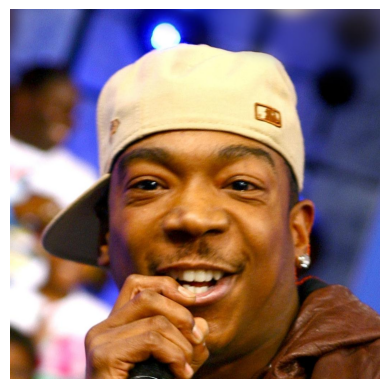

In [14]:
img = Image.open(DATASET_PATH + "/CelebAMask-HQ/CelebA-HQ-img/1000.jpg")
plt.imshow(img)
plt.axis("off")

Download the txt files from the DiffAssemble repository that define the data split between training and testing

In [15]:
%%bash

if [ "$IN_COLAB" == "0" ]; then
  echo "Skipping download (IN_COLAB is false)"
  exit 0
fi

[ -f CelebA-HQ_test.txt ] && rm CelebA-HQ_test.txt
[ -f CelebA-HQ_train.txt ] && rm CelebA-HQ_train.txt

wget -q https://raw.githubusercontent.com/IIT-PAVIS/DiffAssemble/refs/heads/release/datasets/data_splits/CelebA-HQ_test.txt
wget -q https://raw.githubusercontent.com/IIT-PAVIS/DiffAssemble/refs/heads/release/datasets/data_splits/CelebA-HQ_train.txt

mkdir -p $DATASET_PATH
mv CelebA-HQ_test.txt $DATASET_PATH
mv CelebA-HQ_train.txt $DATASET_PATH

ls $DATASET_PATH

Skipping download (IN_COLAB is false)


# Inference

In [ ]:
from dataset_celeb_rot import CelebA_DataSet
from puzzle_dataset import Puzzle_Dataset_ROT